# Analyze A/B Test Results 

The current notebook is organized into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('group=="treatment" & landing_page=="old_page"').count()


user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

It seems that there is no null values

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


-figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use your answer to create a new dataset that meets the specifications. Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2=df.drop(df.query('group=="treatment" & landing_page=="old_page" | group=="control" & landing_page=="new_page"').index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** to answer the questions below.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.loc[df2.user_id.duplicated(),:]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
df2.drop([2893],axis=0,inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [14]:
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#We can find the converted probability for each group like this:
df2.groupby(['group'])['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

In [16]:
#converted probability for control group
control_prob=df2.query('group=="control"')['converted'].mean()
control_prob

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_prob=df2.query('group=="treatment"')['converted'].mean()
treatment_prob

0.11880806551510564

>Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=control_prob-treatment_prob
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
new_prob=df2.query('landing_page=="new_page"').count()/df2.count()
new_prob

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Answer** 
The difference between the conversion rates of the two groups is very small. There are fewer people who convert from the new page to the old page than people who convert from the old page to the new page. but the converted probabillity of each group is approaximately equal, which means we have no evidence that the old page is more preferable.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  



>**Answer** 


>Null hypothesis **$H_0$** :**$p_{new}$** - **$p_{old}$** <= 0

>Alternative hypothesis **$H_1$** : **$p_{new}$** - **$p_{old}$** > 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
new_p=round(df2.converted.mean(),4)
new_p

0.1196

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
old_p=round(df2.converted.mean(),4)
old_p

0.1196

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [22]:
num_new=df2.query('landing_page=="new_page"').user_id.nunique()
num_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
num_old=df2.query('landing_page=="old_page"').user_id.nunique()
num_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [24]:
#Defining a function for simulating samples.
def simulate_sample(num1,num2,size,p1):
    x=np.random.choice([num1,num2],size=size,p=[p1,1-p1]).mean()
    return x

new_page_converted=simulate_sample(1,0,num_new,new_p)
new_page_converted

0.11942743100956575

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [25]:
old_page_converted=simulate_sample(1,0,num_old,old_p)
old_page_converted

0.12007654501149552

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
diff=new_page_converted-old_page_converted
diff

-0.00064911400192976809


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [27]:
# Sampling distribution 
p_diffs = []

for i in range(10000):
    new_page_converted=simulate_sample(1,0,num_new,new_p)
    old_page_converted=simulate_sample(1,0,num_old,old_p)

    
    p_diffs.append(new_page_converted-old_page_converted)

In [28]:
# convert to numpy array
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected? <br><br>

Use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


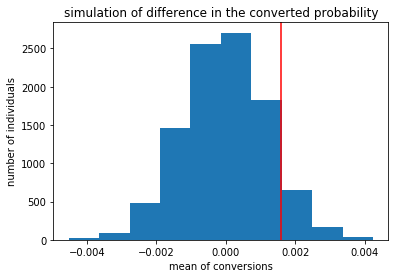

In [29]:
plt.hist(p_diffs)
plt.axvline(obs_diff,c='red')
plt.title('simulation of difference in the converted probability')
plt.xlabel('mean of conversions')
plt.ylabel('number of individuals');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [30]:
#calculating the p-value
(p_diffs>obs_diff).mean()

0.0906

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Answer** 
The coumputed above is the p-value. By comparing our p-value to our type I error threshold 5%, we fail to reject the null hypothesis cause our p-value is greater than alpha. so we have evidence that our statistic was likely to come from the null hypothesis. Which means we should keep the old page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('(landing_page=="old_page") and (converted==1) ').user_id.count()

# number of conversions with the new_page
convert_new =df2.query('(landing_page=="new_page") and (converted==1) ').user_id.count()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page=="old_page"').user_id.count()

# number of individuals who received new_page
n_new = df2.query('landing_page=="new_page"').user_id.count()


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.
The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
The built-in function above will return the z_score, p_value. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 


In [32]:
count = np.array([convert_old,convert_new])
nobs = np.array([n_old, n_new])

import statsmodels.api as sm
#Completing the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count,nobs,alternative='larger')
print(z_score)
print( p_value)

1.31092419842
0.094941687241


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>**Answer** Finidings of both parts agree. The p-value is similar to the one computed earlier,And when we compare Z(alpha) with the Z(score) we fail to reject the null hypothesis. cause 𝑍(0.05) is 1.645 for one-tailed tests and our Z(score)=1.3 is less than 1.645 , So there is no evidence that the new page leads to more conversions.


<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Answer**Logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [33]:
df2['intercept']=1
df2['ab_page']=pd.get_dummies(df2.group)['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [34]:
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result=model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-11-20 14:56 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>**Answer** The p-value associated with ab_page is greater than our type I error threshold of 5%. Which means we fail to reject the null hypothesis. But the coefficient isn't significant.<br><br>
part II alternative hypothesis: conversion rate of the new_page is greater than old_page. This is a one-tailed test. In part III the alternative hypothesis : conversion rate of the new_page is different than old_page .This is a two-tailed test.  

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Answer** It's great to consider other factors in the model which may influence an individual converts or not.
<br> A disadvantage could be adding other factors to the model will make it more complex.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [36]:
# Read the countries.csv
country_df=pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Join with the df2 dataframe
df_merged=df2.set_index('user_id').join(country_df.set_index('user_id'))
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
# Create the necessary dummy variables
df_merged[['UK', 'US','CA']]=pd.get_dummies(df_merged.country)
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 



In [39]:
# Fit your model, and summarize the results
model=sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','UK','US']])
result=model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-11-20 14:56 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
US            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [40]:
#we exponentiate the coefficients for ab_page, UK and US:
round(np.exp(result.params),3)

intercept    0.137
ab_page      0.985
UK           0.960
US           1.010
dtype: float64

In [41]:
#calculate the reciprocal
round(1/np.exp(result.params),3)

intercept    7.310
ab_page      1.015
UK           1.042
US           0.990
dtype: float64


>**Interpreting Results:** <br>
for every one unit decrease in ab_page (new_page) , an indiviual is 1.015 times more likely to be converted. Holding all other variables constant.<br>
for every one unit decrease in UK , an indiviual is 1.042 times more likely to be converted. Holding all other variables constant.<br>
for every one unit increase in US , an indiviual is 1.010 times more likely to be converted. Holding all other variables constant.<br>



>**Conclusion answer** The p-value of our country dummy variables is greater than type I error thershold of 5%. which means the country have no influence on conversions rate. All variables aren't statistically significant. 
